# Data Splitting: Train / Validation / Test

In this notebook we will:

1. **Load** the cleaned **interactions_df** (and optionally **questions_df** / **quizzes_df**).
2. **Define** a student-level split strategy (70% train, 15% val, 15% test).
3. **Apply** the split, ensuring each student’s full history remains in one set.
4. **Verify** distributions (number of students, interactions per split, category balance).
5. **Save** each split to disk for modeling.

## 1. Imports & Data Loading

We import necessary libraries and load the cleaned interaction table produced by *3_etl.ipynb* file.

In [51]:
import pandas as pd
import numpy as np

# Load interactions_df
interactions_df = pd.read_parquet('data/interactions_clean.parquet')
questions_df = pd.read_parquet('data/questions_clean.parquet')
# (Optionally) load question/quiz meta if needed
# quizzes_df = pd.read_parquet('data/quizzes_clean.parquet')

print("Total users:", interactions_df['user_id'].nunique())
print("Total interactions:", len(interactions_df))

Total users: 3524
Total interactions: 603172


## 2. Define Student‐Level Split

We will split **at the user level** to prevent data leakage, that is, the model does not have access to data that it should not see during training, resulting in artificially high metrics and a model that does not generalize well to new data. Performing the split per user ensures that the evaluation is realistic and that the model generalizes well.<br>
We will use the following steps to split the data: 
- Randomly shuffle the list of unique *user_id*s.  
- Allocate 70% to train, 15% to validation, 15% to test.

In [52]:
# Get unique users and shuffle
users = interactions_df['user_id'].unique()
rng = np.random.default_rng(seed=42)
shuffled = rng.permutation(users)

# Compute split sizes
n = len(shuffled)
n_train = int(0.70 * n)
n_val   = int(0.15 * n) + 1 # +1 to ensure n_val is equal to n_test (optional)
# rest goes to test
train_users = shuffled[:n_train]
val_users   = shuffled[n_train:n_train+n_val]
test_users  = shuffled[n_train+n_val:]

print(f"Users: total={n}, train={len(train_users)}, val={len(val_users)}, test={len(test_users)}")


Users: total=3524, train=2466, val=529, test=529


## 3. Filter Interactions per Split

Using the three user-lists above, we create three DataFrames: **train_df**, **val_df**, **test_df**, which contain the interactions of the users assigned to each set.

In [53]:
# Filter
train_df = interactions_df[interactions_df['user_id'].isin(train_users)].reset_index(drop=True)
val_df   = interactions_df[interactions_df['user_id'].isin(val_users)].reset_index(drop=True)
test_df  = interactions_df[interactions_df['user_id'].isin(test_users)].reset_index(drop=True)

print("Interactions per split:")
print(" - train:", len(train_df))
print(" - val:  ", len(val_df))
print(" - test: ", len(test_df))


Interactions per split:
 - train: 420867
 - val:   89809
 - test:  92496


## 4. Verify Distributions

We check if the **distribution of interactions per-user counts** are similar across splits. This helps to ensure fairness and representativeness in the data sets.


TRAIN Users - Median Interactions: 170.67
TRAIN distribution of interactions per user:
count    2466.000000
mean      170.667883
std        97.023355
min         1.000000
25%       109.000000
50%       139.000000
75%       276.000000
max       556.000000
dtype: float64


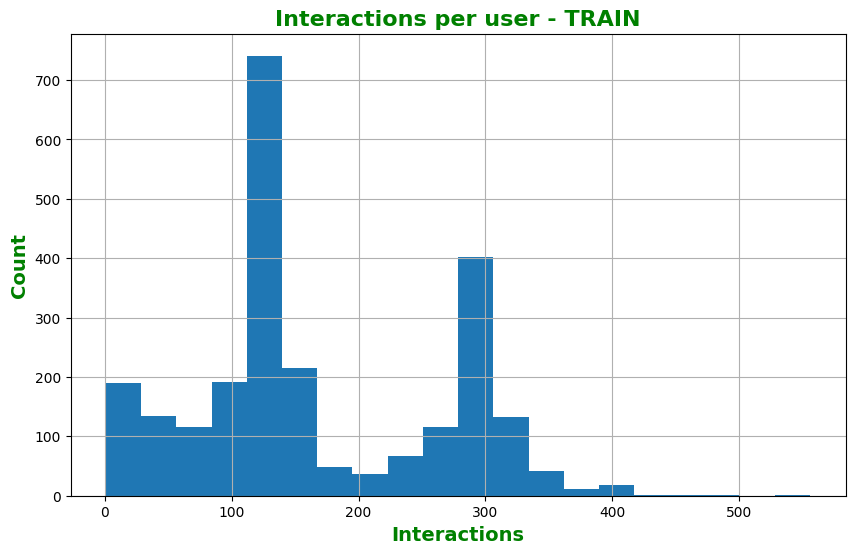


VAL Users - Median Interactions: 169.77
VAL distribution of interactions per user:
count    529.000000
mean     169.771267
std      102.055330
min        1.000000
25%       93.000000
50%      139.000000
75%      291.000000
max      397.000000
dtype: float64


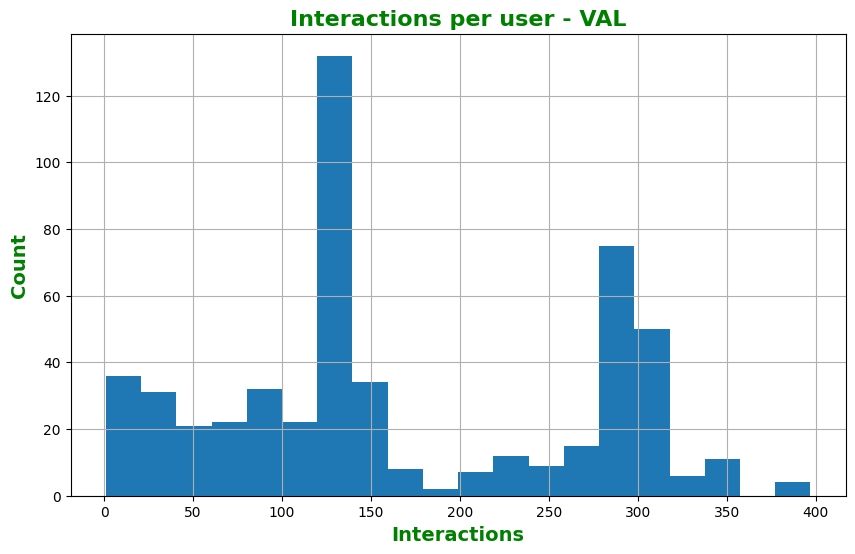


TEST Users - Median Interactions: 174.85
TEST distribution of interactions per user:
count    529.000000
mean     174.850662
std      103.076770
min       10.000000
25%      109.000000
50%      139.000000
75%      291.000000
max      488.000000
dtype: float64


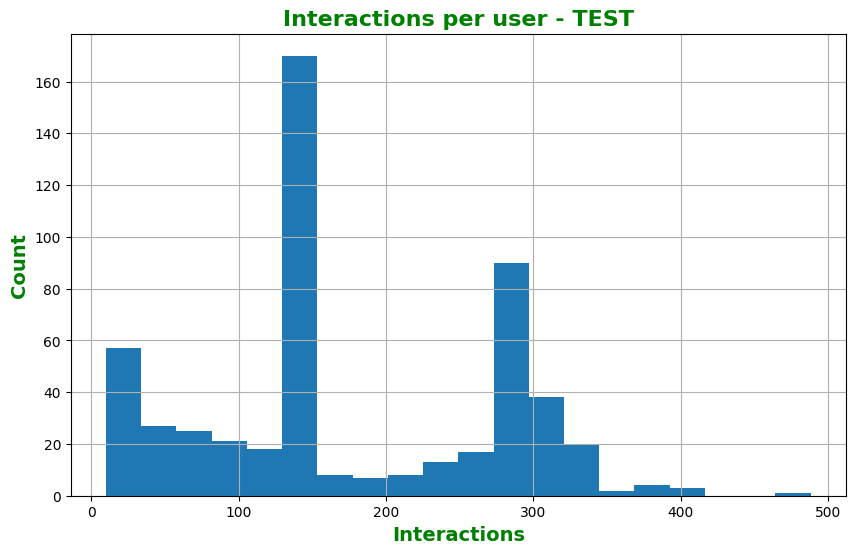

In [54]:
# Interactions per user distribution
import matplotlib.pyplot as plt

for name, df in [('train',train_df), ('val',val_df), ('test',test_df)]:
    user_counts = df.groupby('user_id').size()
    print(f"\n{name.upper()} Users - Median Interactions: {user_counts.mean():.2f}")
    print(100 * "=")
    print(f"{name.upper()} distribution of interactions per user:")
    print(user_counts.describe())
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(user_counts, bins=20)
    plt.title(f"Interactions per user - {name.upper()}", fontsize=16, fontweight="bold", color="Green")
    plt.xlabel("Interactions", fontsize=14, fontweight="bold", color="Green")
    plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
    plt.grid()
    # Save the plot as an image
    plt.savefig(f"images/interactions_per_user_{name}.png")
    plt.show()


As we can see, the distribution of interactions per user is similar in all three datasets. This is important to ensure that the model is not biased towards a specific dataset and that it can generalize well to new data.

We check also if the **distribution of interactions by general category** are similar across splits. For that we first load only the necessary columns from the **questions_df** DataFrame (*id* and *general_cat*) and then merge with each of the interactions DataFrames (**train_df**, **val_df** and **test_df**). This allows us to see the distribution of the general categories in each of the datasets.


TRAIN Category Distribution (%):
general_cat
C                       45.58
Python                  13.01
Shell                    8.90
Programming & Basics     7.24
Math & Stats             5.61
Web & Front-end          5.23
Databases & ORM          4.91
Networking & API         4.40
Javascript               2.87
DevOps & Tools           2.25


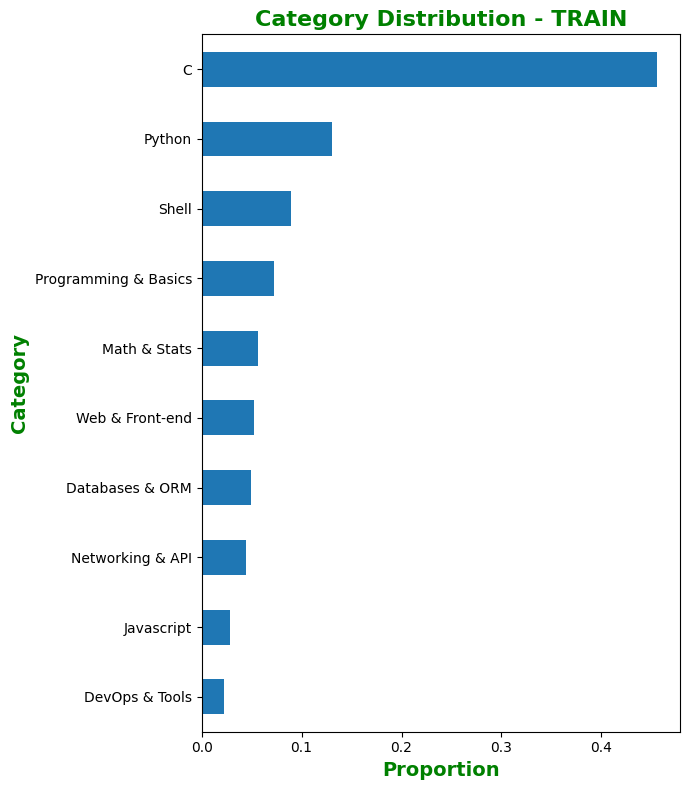


VAL Category Distribution (%):
general_cat
C                       44.94
Python                  13.06
Shell                    9.03
Programming & Basics     7.37
Math & Stats             5.72
Web & Front-end          5.17
Databases & ORM          5.06
Networking & API         4.51
Javascript               2.82
DevOps & Tools           2.31


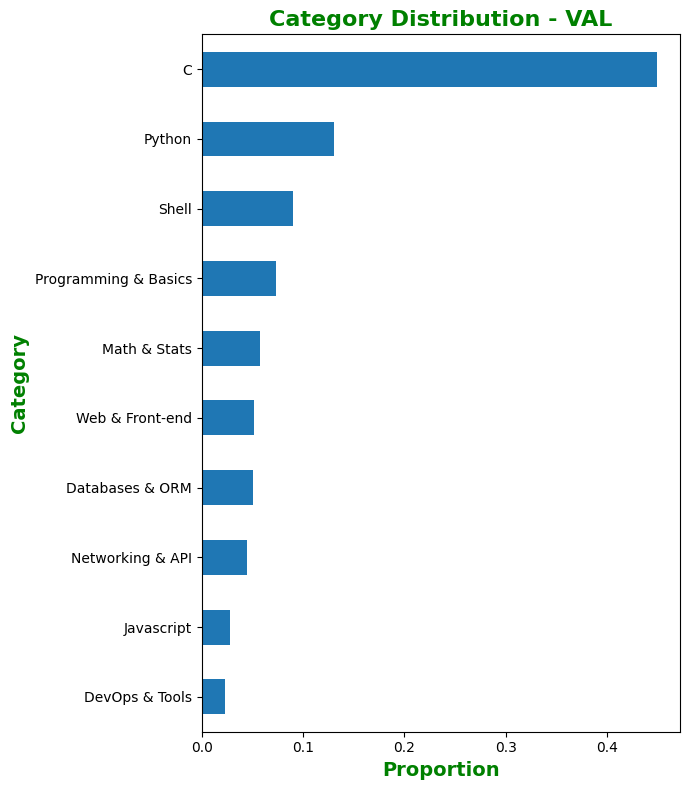


TEST Category Distribution (%):
general_cat
C                       44.84
Python                  13.31
Shell                    8.98
Programming & Basics     7.21
Math & Stats             5.35
Web & Front-end          5.20
Databases & ORM          5.05
Networking & API         4.84
Javascript               2.76
DevOps & Tools           2.47


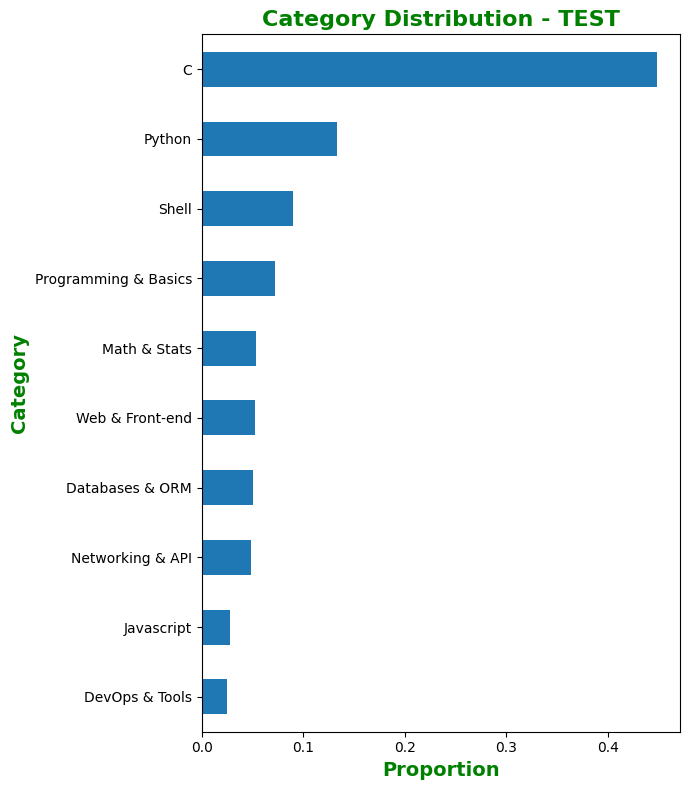

In [55]:
# We load only the necessary columns of questions_df
q_meta = questions_df[['id', 'general_cat']].rename(columns={'id':'question_id'})

for name, df in [('train',train_df), ('val',val_df), ('test',test_df)]:
    # Spot merge to "bring in" general_cat
    df_cat = df.merge(q_meta, on='question_id', how='left')
    
    # We calculate proportions
    cat_dist = df_cat['general_cat'].value_counts(normalize=True).sort_values(ascending=False)
    
    print(f"\n{name.upper()} Category Distribution (%):")
    print((cat_dist * 100).round(2).to_string())
    
    # Plot the distribution
    ax = cat_dist.plot.barh(figsize=(7,8))
    ax.invert_yaxis()
    plt.title(f"Category Distribution - {name.upper()}", fontsize=16, fontweight="bold", color="Green")
    plt.xlabel("Proportion", fontsize=14, fontweight="bold", color="Green")
    plt.ylabel("Category", fontsize=14, fontweight="bold", color="Green")
    plt.tight_layout()
    # Save the plot as an image
    plt.savefig(f"images/category_distribution_{name}.png")
    plt.show()

It is observed that the distributions of interactions by general category are very similar across the training, validation and test sets, confirming that we have maintained a balanced distribution of skills in each split. This is essential to ensure that our models see a representative spectrum of each skill during training and that the evaluation is realistic.

## 5. Save Splits to Disk

Finally, we save the three sets of DataFrames in Parquet format for use in the scripts of the different Knowledge Tracing models.

In [56]:
import os
os.makedirs('data/splits', exist_ok=True)

train_df.to_parquet('data/splits/train.parquet', index=False)
val_df.to_parquet('data/splits/val.parquet', index=False)
test_df.to_parquet('data/splits/test.parquet', index=False)

print("✅ Saved train/val/test splits under data/splits/")

✅ Saved train/val/test splits under data/splits/
